READ THIS FIRST!

This code analyses all the measurements, and checks for errors.

Furthermore this code create's some new features to test the machine learning model with.

Simple explanation:

In ML you use a generally use a dataframe with rows as the measurements and columns with measured values.
Sometimes in ML effects happen which are a combination of some measurements (non-linear effects). 
Classical ML techniques are less good at modelling these effects.
Thats why we create new features (new columns) to express these non-linear effects better.

In [ ]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from itertools import zip_longest
import os

In [2]:
# data = json.load(open("2025-06-15_11-38-56-781937_measure_weight_FORCE_MEASUREMENT_CASE1.json", encoding="utf-8"))
data = json.load(open("2025-06-15_11-39-04-387039_measure_weight_FORCE_MEASUREMENT_CASE.json", encoding="utf-8"))

df = pd.json_normalize(
    data,
    record_path="raw_measurements",
    meta=["version","type","start_time","end_time","sampling_rate","weight_filter","zero_offset","expected_weight","robot_type","eoat_params"],
    errors="ignore"
)

print(df.shape)
print(df.keys())
print(df.head())

(493, 19)
Index(['timestamp', 'value', 'force_vector', 'robot_tcp.timestamp',
       'robot_tcp.flange', 'robot_tcp.tcp_offset', 'robot_tcp.velocity_linear',
       'robot_tcp.velocity_angular', 'robot_tcp.joint_angles', 'version',
       'type', 'start_time', 'end_time', 'sampling_rate', 'weight_filter',
       'zero_offset', 'expected_weight', 'robot_type', 'eoat_params'],
      dtype='object')
      timestamp  value          force_vector  robot_tcp.timestamp  \
0  1.749980e+09 -0.054   [0.603, 0.618, 9.0]         1.749980e+09   
1  1.749980e+09 -0.055    [0.647, 0.59, 9.0]         1.749980e+09   
2  1.749980e+09 -0.055   [0.683, 0.56, 10.0]         1.749980e+09   
3  1.749980e+09 -0.055  [0.711, 0.529, 11.0]         1.749980e+09   
4  1.749980e+09 -0.055   [0.73, 0.502, 11.0]         1.749980e+09   

                                    robot_tcp.flange  \
0  [[-0.5583840012550354, -0.3735954165458679, -0...   
1  [[-0.5583451986312866, -0.37359368801116943, -...   
2  [[-0.558345198

In [3]:
# Renaming and ordering the data.

df[["Mx","My","Fz"]] = pd.DataFrame(df.pop("force_vector").tolist(), index=df.index)

flange = pd.DataFrame(df.pop("robot_tcp.flange").tolist(), index=df.index)
df[["flange_tx","flange_ty","flange_tz"]] = pd.DataFrame(flange[0].tolist(), index=df.index)
df[["flange_qw","flange_qx","flange_qy","flange_qz"]] = pd.DataFrame(flange[1].tolist(), index=df.index)

tcp_off = pd.DataFrame(df.pop("robot_tcp.tcp_offset").tolist(), index=df.index)
df[["tcp_tx","tcp_ty","tcp_tz"]] = pd.DataFrame(tcp_off[0].tolist(), index=df.index)
df[["tcp_qw","tcp_qx","tcp_qy","tcp_qz"]] = pd.DataFrame(tcp_off[1].tolist(), index=df.index)

df[["tcp_vx","tcp_vy","tcp_vz"]] = pd.DataFrame(df.pop("robot_tcp.velocity_linear").tolist(), index=df.index)

df[["tcp_wx","tcp_wy","tcp_wz"]] = pd.DataFrame(df.pop("robot_tcp.velocity_angular").tolist(), index=df.index)

df[["joint_base","joint_shoulder","joint_elbow","joint_wrist_1","joint_wrist_2","joint_wrist_3"]] = (
    pd.DataFrame(df.pop("robot_tcp.joint_angles").tolist(), index=df.index)
)


t_num = pd.to_numeric(df["timestamp"], errors="coerce")
t_rel_ms_num = (t_num - t_num.iloc[0]) * 1000
t_dt = pd.to_datetime(df["timestamp"], errors="coerce")
t_rel_ms_dt = (t_dt - t_dt.iloc[0]) / pd.to_timedelta(1, "ms")
time_ms = t_rel_ms_num.fillna(t_rel_ms_dt)


rt_num = pd.to_numeric(df["robot_tcp.timestamp"], errors="coerce")
rt_rel_ms = (rt_num - rt_num.iloc[0]) * 1000

In [4]:
print(time_ms)
print(len(time_ms))
print(df.keys())

0        0.000000
1        1.042843
2        2.041817
3        3.042459
4        4.041672
          ...    
488    495.506763
489    496.506214
490    497.508049
491    498.506069
492    499.506950
Name: timestamp, Length: 493, dtype: float64
493
Index(['timestamp', 'value', 'robot_tcp.timestamp', 'version', 'type',
       'start_time', 'end_time', 'sampling_rate', 'weight_filter',
       'zero_offset', 'expected_weight', 'robot_type', 'eoat_params', 'Mx',
       'My', 'Fz', 'flange_tx', 'flange_ty', 'flange_tz', 'flange_qw',
       'flange_qx', 'flange_qy', 'flange_qz', 'tcp_tx', 'tcp_ty', 'tcp_tz',
       'tcp_qw', 'tcp_qx', 'tcp_qy', 'tcp_qz', 'tcp_vx', 'tcp_vy', 'tcp_vz',
       'tcp_wx', 'tcp_wy', 'tcp_wz', 'joint_base', 'joint_shoulder',
       'joint_elbow', 'joint_wrist_1', 'joint_wrist_2', 'joint_wrist_3'],
      dtype='object')


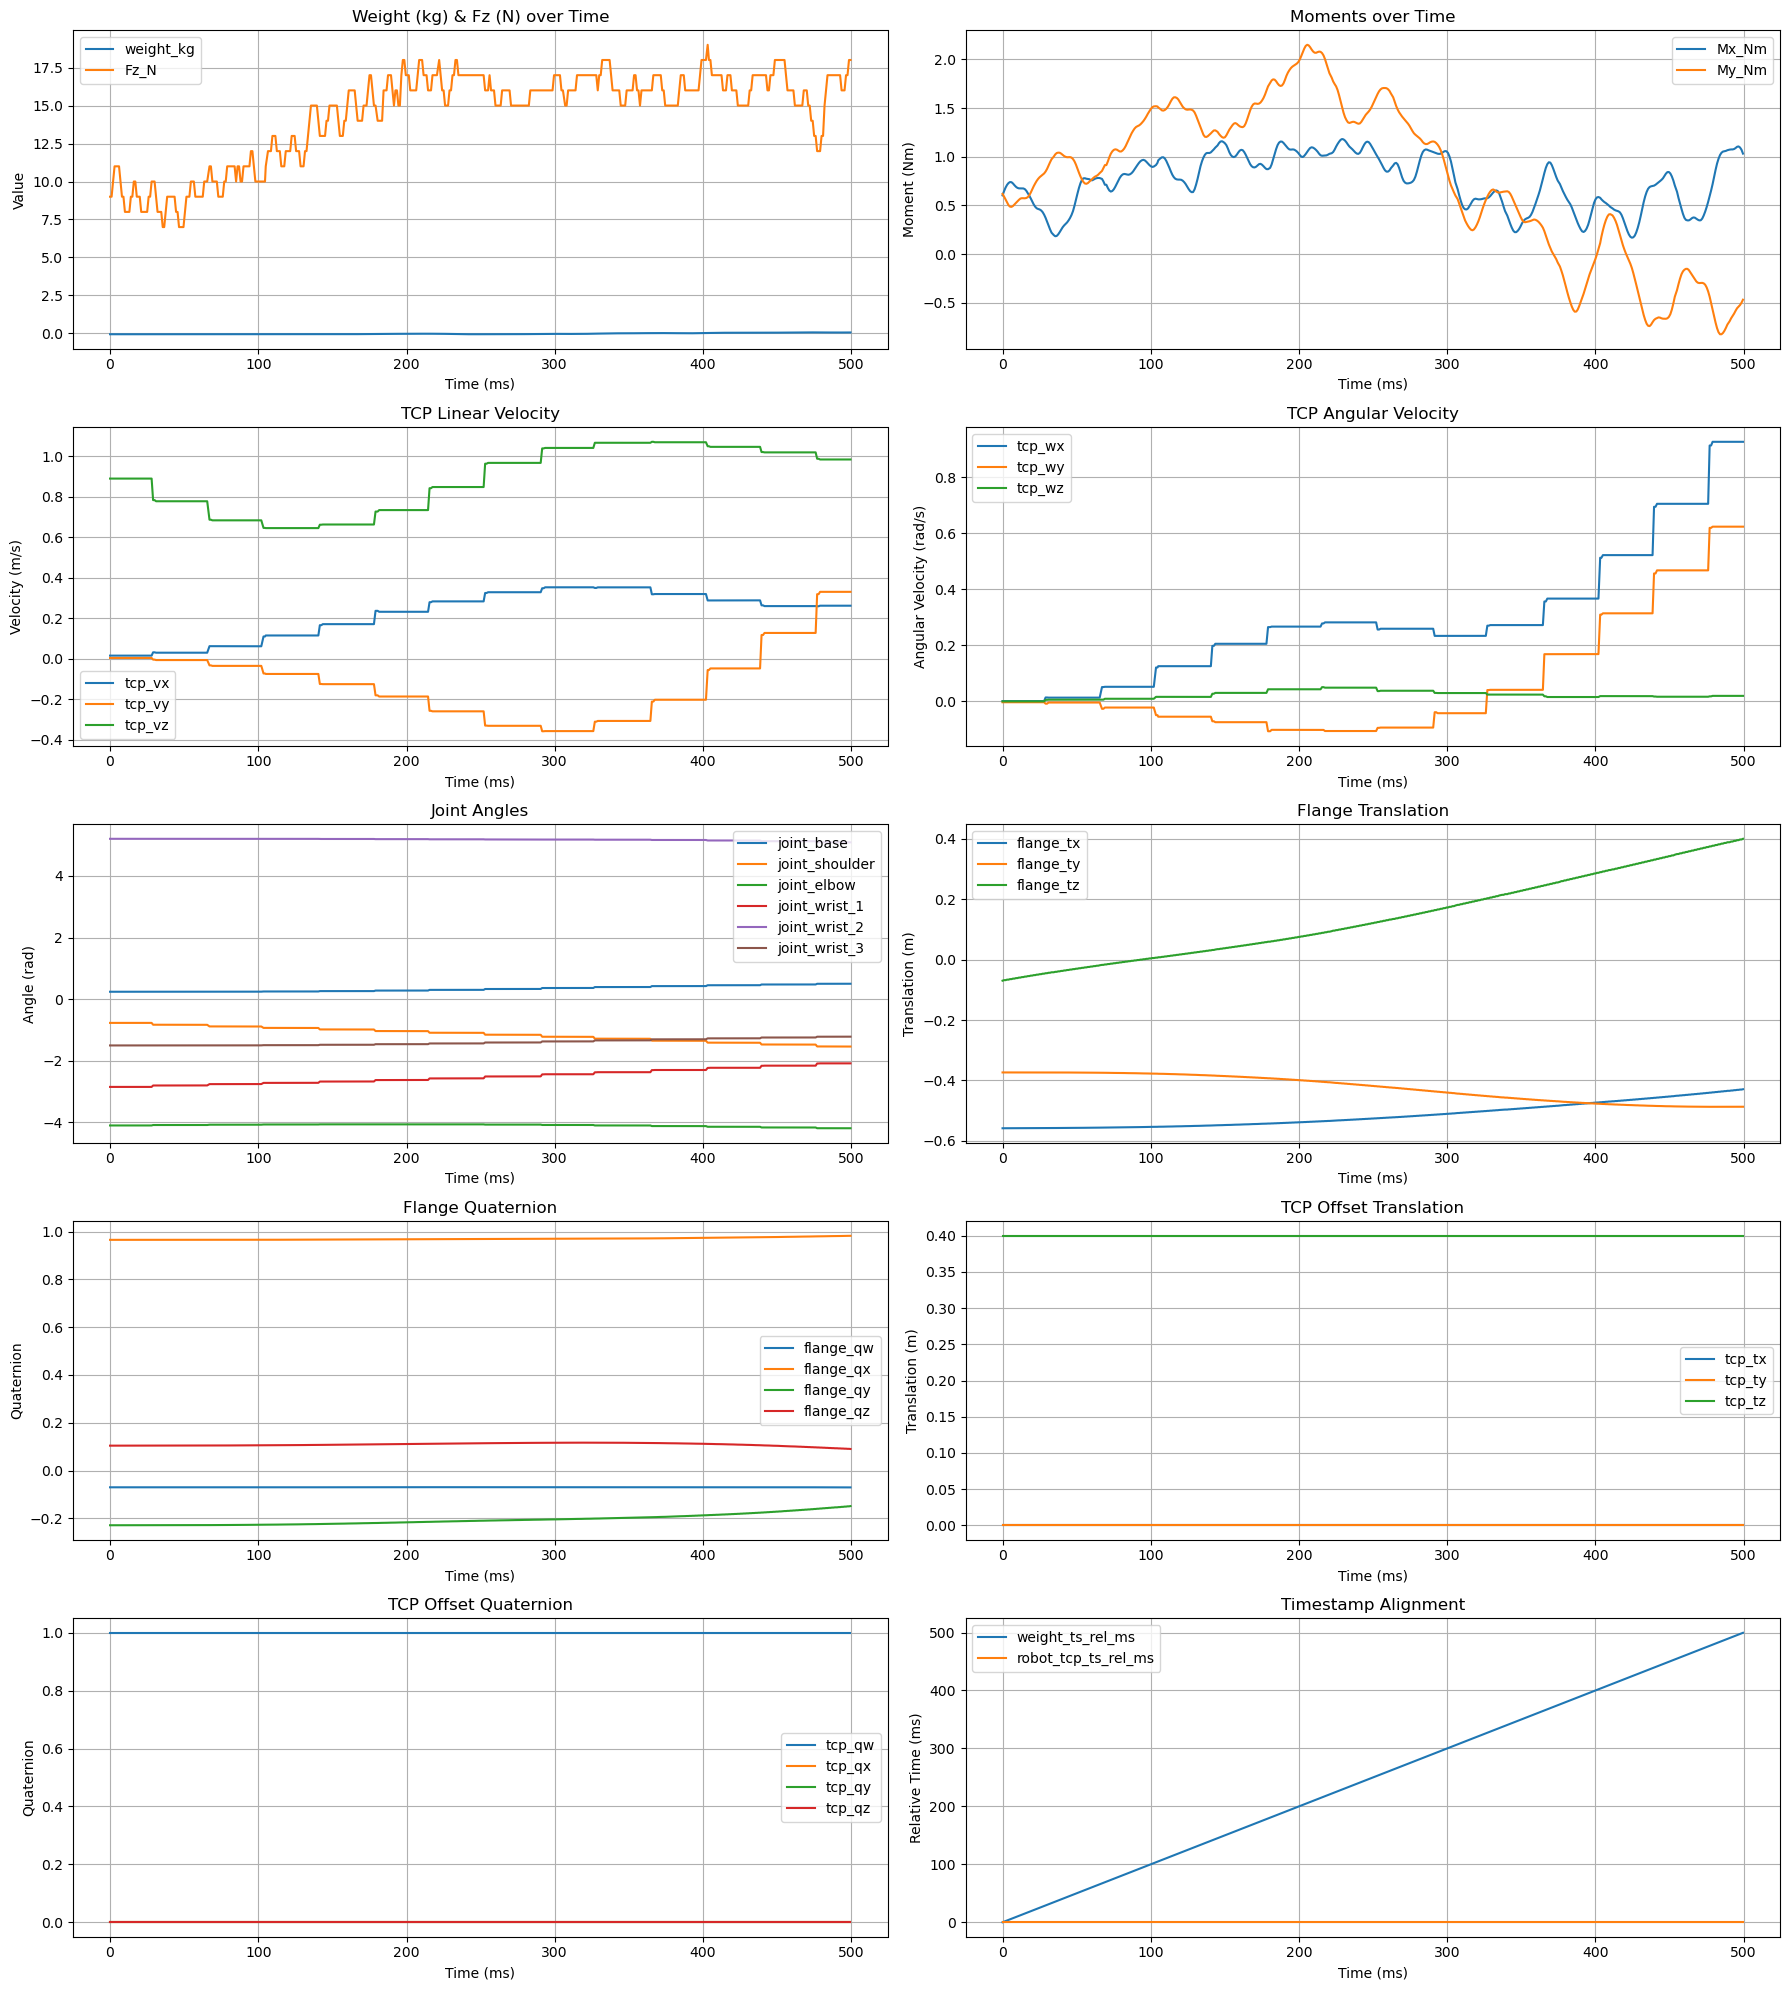

In [5]:
plt.figure(figsize=(18, 20))

# 1) Weight & Fz (N) together
plt.subplot(5, 2, 1)
plt.plot(time_ms, df["value"], label="weight_kg")
plt.plot(time_ms, df["Fz"], label="Fz_N")
plt.xlabel("Time (ms)")
plt.ylabel("Value")
plt.title("Weight (kg) & Fz (N) over Time")
plt.legend()
plt.grid(True)

# 2) Moments Mx, My (Nm)
plt.subplot(5, 2, 2)
plt.plot(time_ms, df["Mx"], label="Mx_Nm")
plt.plot(time_ms, df["My"], label="My_Nm")
plt.xlabel("Time (ms)")
plt.ylabel("Moment (Nm)")
plt.title("Moments over Time")
plt.legend()
plt.grid(True)

# 3) TCP linear velocity (m/s)
plt.subplot(5, 2, 3)
plt.plot(time_ms, df["tcp_vx"], label="tcp_vx")
plt.plot(time_ms, df["tcp_vy"], label="tcp_vy")
plt.plot(time_ms, df["tcp_vz"], label="tcp_vz")
plt.xlabel("Time (ms)")
plt.ylabel("Velocity (m/s)")
plt.title("TCP Linear Velocity")
plt.legend()
plt.grid(True)

# 4) TCP angular velocity (rad/s)
plt.subplot(5, 2, 4)
plt.plot(time_ms, df["tcp_wx"], label="tcp_wx")
plt.plot(time_ms, df["tcp_wy"], label="tcp_wy")
plt.plot(time_ms, df["tcp_wz"], label="tcp_wz")
plt.xlabel("Time (ms)")
plt.ylabel("Angular Velocity (rad/s)")
plt.title("TCP Angular Velocity")
plt.legend()
plt.grid(True)

# 5) Joint angles (rad)
plt.subplot(5, 2, 5)
for c in ["joint_base","joint_shoulder","joint_elbow","joint_wrist_1","joint_wrist_2","joint_wrist_3"]:
    plt.plot(time_ms, df[c], label=c)
plt.xlabel("Time (ms)")
plt.ylabel("Angle (rad)")
plt.title("Joint Angles")
plt.legend()
plt.grid(True)
        
# 6) Flange translation (m)
plt.subplot(5, 2, 6)
plt.plot(time_ms, df["flange_tx"], label="flange_tx")
plt.plot(time_ms, df["flange_ty"], label="flange_ty")
plt.plot(time_ms, df["flange_tz"], label="flange_tz")
plt.xlabel("Time (ms)")
plt.ylabel("Translation (m)")
plt.title("Flange Translation")
plt.legend()
plt.grid(True)

# 7) Flange quaternion (unitless)
plt.subplot(5, 2, 7)
for c in ["flange_qw","flange_qx","flange_qy","flange_qz"]:
    plt.plot(time_ms, df[c], label=c)
plt.xlabel("Time (ms)")
plt.ylabel("Quaternion")
plt.title("Flange Quaternion")
plt.legend()
plt.grid(True)

# 8) TCP offset translation (m)
plt.subplot(5, 2, 8)
plt.plot(time_ms, df["tcp_tx"], label="tcp_tx")
plt.plot(time_ms, df["tcp_ty"], label="tcp_ty")
plt.plot(time_ms, df["tcp_tz"], label="tcp_tz")
plt.xlabel("Time (ms)")
plt.ylabel("Translation (m)")
plt.title("TCP Offset Translation")
plt.legend()
plt.grid(True)

# 9) TCP offset quaternion (unitless)
plt.subplot(5, 2, 9)
for c in ["tcp_qw","tcp_qx","tcp_qy","tcp_qz"]:
    plt.plot(time_ms, df[c], label=c)
plt.xlabel("Time (ms)")
plt.ylabel("Quaternion")
plt.title("TCP Offset Quaternion")
plt.legend()
plt.grid(True)

# 10) Robot TCP timestamp vs weight timestamp (ms)
plt.subplot(5, 2, 10)
plt.plot(time_ms, time_ms, label="weight_ts_rel_ms")
plt.plot(time_ms, rt_rel_ms, label="robot_tcp_ts_rel_ms")
plt.xlabel("Time (ms)")
plt.ylabel("Relative Time (ms)")
plt.title("Timestamp Alignment")
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.show()

In [6]:
# feeding the raw timeseries in to a machinelearning model is a bit diffucult, unless you use neural networks.
# so we start reducing the timeseries to singular values.

In [7]:
import numpy as np
import pandas as pd

def extract_singular_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Compress a time series into a single-row feature vector without assuming fixed sampling.
    - Uses per-step dt from timestamps (ms) to compute derivatives and integrals.
    - Derives median fs (Hz) from dt for reporting.
    - Resamples to a uniform grid at fs_med for FFT features via linear interpolation.
    """
    df = df.copy()  # don't mutate caller
    out = {}

    # ---------- Time base (no hardcoding) ----------
    # Accepts a precomputed "time_ms" column; otherwise computes from df["timestamp"].
    if "time_ms" in df.columns:
        time_ms = pd.to_numeric(df["time_ms"], errors="coerce")
    else:
        t_num = pd.to_numeric(df.get("timestamp"), errors="coerce")
        t_rel_ms_num = (t_num - t_num.iloc[0]) * 1000 if t_num.notna().any() else pd.Series(np.nan, index=df.index)
        t_dt = pd.to_datetime(df.get("timestamp"), errors="coerce")
        t_rel_ms_dt = (t_dt - t_dt.iloc[0]) / pd.to_timedelta(1, "ms") if t_dt.notna().any() else pd.Series(np.nan, index=df.index)
        time_ms = t_rel_ms_num.fillna(t_rel_ms_dt)

    # Enforce monotonic, fill small gaps
    time_ms = time_ms.astype(float)
    # If any nans at start/end, forward/back fill
    time_ms = time_ms.ffill().bfill()
    # Ensure non-decreasing
    time_ms = np.maximum.accumulate(time_ms.values)
    time_ms = pd.Series(time_ms, index=df.index)

    # dt (seconds) per step
    dt_s = (time_ms.diff() / 1000.0)
    # replace first NaN and any zeros/negatives with median positive step
    med_dt = float(dt_s[dt_s > 0].median()) if (dt_s > 0).any() else 1e-3
    dt_s = dt_s.replace([np.inf, -np.inf], np.nan).fillna(med_dt).clip(lower=1e-9)

    # sampling statistics
    fs_med = float(1.0 / med_dt)
    out["fs_hz"] = fs_med
    duration_s = float((time_ms.iloc[-1] - time_ms.iloc[0]) / 1000.0) if len(time_ms) else 0.0
    out["duration_s"] = duration_s
    out["n_samples"] = int(len(df))

    # ---------- Pass through ONLY the raw constant 'value' ----------
    if "value" in df.columns:
        v = pd.to_numeric(df["value"], errors="coerce")
        out["value"] = float(v.dropna().iloc[0]) if v.notna().any() else np.nan

    # ---------- Force vector ----------
    for c in ["Fx", "Fy"]:
        if c not in df.columns:
            df[c] = 0.0
    if "Fz" not in df.columns:
        df["Fz"] = 0.0
    df["F_norm"] = np.sqrt((df[["Fx","Fy","Fz"]]**2).sum(axis=1))

    # ---------- Linear / angular speeds ----------
    for need in ["tcp_vx","tcp_vy","tcp_vz","tcp_wx","tcp_wy","tcp_wz"]:
        if need not in df.columns:
            df[need] = 0.0
    df["v_lin"] = np.sqrt((df[["tcp_vx","tcp_vy","tcp_vz"]]**2).sum(axis=1))
    df["omega"] = np.sqrt((df[["tcp_wx","tcp_wy","tcp_wz"]]**2).sum(axis=1))

    # ---------- Power & Work (linear) ----------
    df["P_lin"] = df["Fx"]*df["tcp_vx"] + df["Fy"]*df["tcp_vy"] + df["Fz"]*df["tcp_vz"]
    W_lin = float((df["P_lin"] * dt_s).sum())  # time-weighted integral (J)
    out["W_lin"] = W_lin
    out["P_lin_mean"] = float((df["P_lin"] * dt_s).sum() / duration_s) if duration_s > 0 else np.nan

    # ---------- Derivatives (time-aware) ----------
    def deriv(col):
        s = pd.to_numeric(df[col], errors="coerce").astype(float)
        return s.diff().div(dt_s).replace([np.inf,-np.inf], np.nan).fillna(0.0)

    for col in ["tcp_vx","tcp_vy","tcp_vz"]:
        df[f"a_{col[-1]}"] = deriv(col)
    for col in ["tcp_wx","tcp_wy","tcp_wz"]:
        df[f"alpha_{col[-1]}"] = deriv(col)
    for col in ["Fx","Fy","Fz"]:
        df[f"dF_{col.lower()}"] = deriv(col)

    df["jerk"] = deriv("v_lin")

    # ---------- Alignment (force vs velocity) ----------
    eps = 1e-12
    num = df["Fx"]*df["tcp_vx"] + df["Fy"]*df["tcp_vy"] + df["Fz"]*df["tcp_vz"]
    df["align_F_v"] = num / (df["F_norm"]*df["v_lin"] + eps)
    out["align_F_v_mean"] = float(np.nanmean(df["align_F_v"]))

    # ---------- Path length (time-weighted) ----------
    out["path_len_total"] = float((df["v_lin"] * dt_s).sum())

    # ---------- Orientation change per step (Δθ) ----------
    # Prefer flange quaternion, fall back to tcp
    qcols = ["flange_qw","flange_qx","flange_qy","flange_qz"]
    if not set(qcols).issubset(df.columns):
        qcols = ["tcp_qw","tcp_qx","tcp_qy","tcp_qz"]
    if set(qcols).issubset(df.columns):
        q = df[qcols].to_numpy(dtype=float)
        # normalize
        q = q / (np.linalg.norm(q, axis=1, keepdims=True) + eps)
        q_prev = np.vstack([q[0], q[:-1]])
        dot = np.sum(q*q_prev, axis=1)
        dot = np.clip(np.abs(dot), 0.0, 1.0 - 1e-9)
        dtheta = 2.0 * np.arccos(dot)
    else:
        dtheta = np.zeros(len(df))
    df["dtheta"] = dtheta
    out["dtheta_sum"] = float(np.nansum(df["dtheta"]))
    out["dtheta_max"] = float(np.nanmax(df["dtheta"])) if len(df) else np.nan
    out["dtheta_mean"] = float(np.nanmean(df["dtheta"]))

    # ---------- Joint features ----------
    joint_cols = [c for c in ["joint_base","joint_shoulder","joint_elbow","joint_wrist_1","joint_wrist_2","joint_wrist_3"] if c in df.columns]
    q_sync_mean = np.nan
    if joint_cols:
        for jc in joint_cols:
            s = pd.to_numeric(df[jc], errors="coerce").astype(float)
            out[f"{jc}_mean"]  = float(np.nanmean(s))
            out[f"{jc}_std"]   = float(np.nanstd(s))
            out[f"{jc}_range"] = float(np.nanmax(s) - np.nanmin(s))
            sp = deriv(jc)
            out[f"{jc}_speed_mean"] = float(np.nanmean(sp))
            out[f"{jc}_speed_std"]  = float(np.nanstd(sp))
        # Synchrony across joints
        speed_mat = np.vstack([deriv(jc).to_numpy() for jc in joint_cols]).T
        q_sync_series = np.nanstd(speed_mat, axis=1)
        q_sync_mean = float(np.nanmean(q_sync_series))
    out["q_sync_mean"] = q_sync_mean

    # ---------- Aggregate stats (time-agnostic) ----------
    def stats(prefix, series):
        s = pd.to_numeric(series, errors="coerce").astype(float).replace([np.inf,-np.inf], np.nan).dropna()
        if s.empty:
            for k in ["mean","std","rms","min","max","p10","p90"]:
                out[f"{prefix}_{k}"] = np.nan
            return
        out[f"{prefix}_mean"] = float(s.mean())
        out[f"{prefix}_std"]  = float(s.std(ddof=0))
        out[f"{prefix}_rms"]  = float(np.sqrt(np.mean(np.square(s))))
        out[f"{prefix}_min"]  = float(s.min())
        out[f"{prefix}_max"]  = float(s.max())
        out[f"{prefix}_p10"]  = float(np.percentile(s, 10))
        out[f"{prefix}_p90"]  = float(np.percentile(s, 90))

    stats("v_lin",  df["v_lin"])
    stats("omega",  df["omega"])
    stats("F_norm", df["F_norm"])
    stats("P_lin",  df["P_lin"])
    stats("jerk",   df["jerk"])
    stats("dtheta", df["dtheta"])

    # Zero-cross rate of |dF| per second (normalized by duration)
    dF_mag = np.sqrt((df[[c for c in ["dF_fx","dF_fy","dF_fz"] if c in df.columns]]**2).sum(axis=1))
    if len(dF_mag) > 1 and duration_s > 0:
        signs = np.sign(dF_mag.values)
        zc = np.count_nonzero(signs[1:] * signs[:-1] < 0)
        out["F_norm_zcr_per_s"] = float(zc / duration_s)
    else:
        out["F_norm_zcr_per_s"] = np.nan

    # ---------- Quality ----------
    out["missing_rate"] = float(df.isna().mean().mean())
    # 3*IQR outlier count over numeric columns
    outlier_count = 0
    for c in df.select_dtypes(include=[np.number]).columns:
        x = df[c].to_numpy()
        x = x[np.isfinite(x)]
        if x.size == 0: 
            continue
        q1, q3 = np.percentile(x, [25, 75])
        iqr = q3 - q1
        lo, hi = q1 - 3*iqr, q3 + 3*iqr
        outlier_count += int(((x < lo) | (x > hi)).sum())
    out["outlier_count"] = float(outlier_count)

    # ---------- FFT features (uniformized at fs_med) ----------
    # Build uniform grid using median fs; interpolate original (possibly irregular) data.
    def fft_features(signal, name):
        sig = pd.to_numeric(signal, errors="coerce").astype(float).replace([np.inf,-np.inf], np.nan)
        if len(sig) < 4 or duration_s <= 0 or fs_med <= 0:
            for k in ["f_dominant","f_centroid","band_low","band_mid","band_high"]:
                out[f"{name}_{k}"] = np.nan
            return

        t = time_ms.values / 1000.0  # seconds
        # Uniform grid
        t_uniform = np.arange(t[0], t[-1] + 1e-12, 1.0/fs_med)
        # Interpolation (linear, fill with edge values)
        sig_np = sig.to_numpy()
        # Fill internal NaNs by linear interpolation on original timeline first
        not_nan = np.isfinite(sig_np)
        if not_nan.sum() < 2:
            for k in ["f_dominant","f_centroid","band_low","band_mid","band_high"]:
                out[f"{name}_{k}"] = np.nan
            return
        sig_np = pd.Series(sig_np).interpolate(limit_direction="both").to_numpy()
        sig_uniform = np.interp(t_uniform, t, sig_np)

        # Remove DC
        sig_uniform = sig_uniform - np.mean(sig_uniform)
        n = sig_uniform.size
        if n < 4:
            for k in ["f_dominant","f_centroid","band_low","band_mid","band_high"]:
                out[f"{name}_{k}"] = np.nan
            return

        nfft = 1 << (n - 1).bit_length()
        fft = np.fft.rfft(sig_uniform, n=nfft)
        freqs = np.fft.rfftfreq(nfft, d=1.0/fs_med)
        psd = (np.abs(fft)**2) / nfft
        if psd.size <= 1:
            for k in ["f_dominant","f_centroid","band_low","band_mid","band_high"]:
                out[f"{name}_{k}"] = np.nan
            return

        psd_no_dc = psd.copy(); psd_no_dc[0] = 0.0
        dom_idx = int(np.argmax(psd_no_dc))
        f_dom = float(freqs[dom_idx]) if dom_idx < len(freqs) else np.nan
        psd_sum = np.sum(psd)
        f_cent = float(np.sum(freqs * psd) / psd_sum) if psd_sum > 0 else np.nan

        nyq = fs_med / 2.0
        b1, b2 = 0.1*nyq, 0.3*nyq
        def band_frac(flo, fhi):
            idx = (freqs >= flo) & (freqs < fhi)
            p = float(np.sum(psd[idx]))
            return p/psd_sum if psd_sum > 0 else np.nan

        out[f"{name}_f_dominant"] = f_dom
        out[f"{name}_f_centroid"] = f_cent
        out[f"{name}_band_low"]   = band_frac(0.0, b1 if b1 > 0 else 1e-9)
        out[f"{name}_band_mid"]   = band_frac(b1, b2) if b2 > b1 else 0.0
        out[f"{name}_band_high"]  = band_frac(b2, nyq) if nyq > b2 else 0.0

    fft_features(df["v_lin"],   "v_lin")
    fft_features(df["omega"],   "omega")
    fft_features(df["F_norm"],  "F_norm")
    fft_features(df["P_lin"],   "P_lin")

    return pd.DataFrame([out])


In [8]:
# after your preprocessing
df["time_ms"] = time_ms   # keep using your computed time base
features = extract_singular_features(df)
print(features.head())    # already a DataFrame
print(features.keys())

         fs_hz  duration_s  n_samples  value     W_lin  P_lin_mean  \
0  1000.072485    0.499507        493 -0.054  6.501614    12.97551   

   align_F_v_mean  path_len_total  dtheta_sum  dtheta_max  ...  \
0        0.947641        0.469134    0.206708    0.002513  ...   

   F_norm_f_dominant  F_norm_f_centroid  F_norm_band_low  F_norm_band_mid  \
0           1.953267          10.828892         0.934998         0.054512   

   F_norm_band_high  P_lin_f_dominant  P_lin_f_centroid  P_lin_band_low  \
0           0.01049          1.953267          5.676894        0.973957   

   P_lin_band_mid  P_lin_band_high  
0        0.021299         0.004743  

[1 rows x 104 columns]
Index(['fs_hz', 'duration_s', 'n_samples', 'value', 'W_lin', 'P_lin_mean',
       'align_F_v_mean', 'path_len_total', 'dtheta_sum', 'dtheta_max',
       ...
       'F_norm_f_dominant', 'F_norm_f_centroid', 'F_norm_band_low',
       'F_norm_band_mid', 'F_norm_band_high', 'P_lin_f_dominant',
       'P_lin_f_centroid', 'P_l

In [9]:
import os, json
import pandas as pd

data_dir = "force_cases_batch_1"

# All json files in the folder
json_files = [f for f in os.listdir(data_dir) if f.endswith(".json")]

all_features = []
bad_files = []

for fname in json_files:
    fpath = os.path.join(data_dir, fname)
    try:
        with open(fpath, "r", encoding="utf-8") as f:
            data = json.load(f)
            print(f"✅ {fname} is valid")
    except json.JSONDecodeError as e:
        print(f"❌ {fname} is INVALID JSON -> {e}")
        bad_files.append(fname)
        continue
    
    # --- Step 2: Normalize ---
    df = pd.json_normalize(
        data,
        record_path="raw_measurements",
        meta=[
            "version","type","start_time","end_time","sampling_rate",
            "weight_filter","zero_offset","expected_weight",
            "robot_type","eoat_params"
        ],
        errors="ignore"
    )

    # --- Step 3: Renaming / expanding (NON-DESTRUCTIVE) ---
    # keep 'value' and make it numeric
    if "value" in df.columns:
        df["value"] = pd.to_numeric(df["value"], errors="coerce")
    
    # force_vector -> Mx, My, Fz  (do NOT pop)
    if "force_vector" in df.columns:
        fv = pd.DataFrame(df["force_vector"].tolist(), index=df.index)
        # guard against short inner lists
        while fv.shape[1] < 3:
            fv[f"_pad_{fv.shape[1]}"] = None
        df[["Mx","My","Fz"]] = fv.iloc[:, :3].values
    
    # flange [translation, quaternion]
    if "robot_tcp.flange" in df.columns:
        flange = pd.DataFrame(df["robot_tcp.flange"].tolist(), index=df.index)
        t = pd.DataFrame(flange[0].tolist(), index=df.index)
        q = pd.DataFrame(flange[1].tolist(), index=df.index)
        while t.shape[1] < 3: t[t.shape[1]] = None
        while q.shape[1] < 4: q[q.shape[1]] = None
        df[["flange_tx","flange_ty","flange_tz"]] = t.iloc[:, :3].values
        df[["flange_qw","flange_qx","flange_qy","flange_qz"]] = q.iloc[:, :4].values
    
    # tcp_offset [translation, quaternion]
    if "robot_tcp.tcp_offset" in df.columns:
        tcp_off = pd.DataFrame(df["robot_tcp.tcp_offset"].tolist(), index=df.index)
        t = pd.DataFrame(tcp_off[0].tolist(), index=df.index)
        q = pd.DataFrame(tcp_off[1].tolist(), index=df.index)
        while t.shape[1] < 3: t[t.shape[1]] = None
        while q.shape[1] < 4: q[q.shape[1]] = None
        df[["tcp_tx","tcp_ty","tcp_tz"]] = t.iloc[:, :3].values
        df[["tcp_qw","tcp_qx","tcp_qy","tcp_qz"]] = q.iloc[:, :4].values
    
    # linear velocity
    if "robot_tcp.velocity_linear" in df.columns:
        vl = pd.DataFrame(df["robot_tcp.velocity_linear"].tolist(), index=df.index)
        while vl.shape[1] < 3: vl[vl.shape[1]] = None
        df[["tcp_vx","tcp_vy","tcp_vz"]] = vl.iloc[:, :3].values
    
    # angular velocity
    if "robot_tcp.velocity_angular" in df.columns:
        va = pd.DataFrame(df["robot_tcp.velocity_angular"].tolist(), index=df.index)
        while va.shape[1] < 3: va[va.shape[1]] = None
        df[["tcp_wx","tcp_wy","tcp_wz"]] = va.iloc[:, :3].values
    
    # joint angles
    if "robot_tcp.joint_angles" in df.columns:
        ja = pd.DataFrame(df["robot_tcp.joint_angles"].tolist(), index=df.index)
        while ja.shape[1] < 6: ja[ja.shape[1]] = None
        df[["joint_base","joint_shoulder","joint_elbow","joint_wrist_1","joint_wrist_2","joint_wrist_3"]] = ja.iloc[:, :6].values


    # --- Step 4: Time base ---
    t_num = pd.to_numeric(df["timestamp"], errors="coerce")
    t_rel_ms_num = (t_num - t_num.iloc[0]) * 1000
    t_dt = pd.to_datetime(df["timestamp"], errors="coerce")
    t_rel_ms_dt = (t_dt - t_dt.iloc[0]) / pd.to_timedelta(1, "ms")
    time_ms = t_rel_ms_num.fillna(t_rel_ms_dt)
    df["time_ms"] = time_ms

    rt_num = pd.to_numeric(df["robot_tcp.timestamp"], errors="coerce")
    rt_rel_ms = (rt_num - rt_num.iloc[0]) * 1000
    df["rt_rel_ms"] = rt_rel_ms

    # --- Step 5: Extract features (your extractor from earlier) ---
    feats = extract_singular_features(df)
    feats.insert(0, "sample_id", fname)  # keep filename as ID

    all_features.append(feats)

# --- Step 6: Combine ---
features_df = pd.concat(all_features, ignore_index=True)

print("Final feature table:", features_df.shape)
print(features_df.head())
print("Skipped files:", bad_files)

# Optional: save to CSV
features_df.to_csv("force_cases_batch_1_features.csv", index=False)


✅ 2025-06-15_11-44-34-096154_measure_weight_FORCE_MEASUREMENT_CASE.json is valid
✅ 2025-06-15_11-44-43-798071_measure_weight_FORCE_MEASUREMENT_CASE.json is valid
✅ 2025-06-15_11-45-14-855432_measure_weight_FORCE_MEASUREMENT_CASE.json is valid
✅ 2025-06-15_11-45-24-472373_measure_weight_FORCE_MEASUREMENT_CASE.json is valid
✅ 2025-06-15_11-48-35-226293_measure_weight_FORCE_MEASUREMENT_CASE.json is valid
✅ 2025-06-15_11-48-35-743572_measure_weight_FORCE_MEASUREMENT_CASE.json is valid
✅ 2025-06-15_11-48-45-906488_measure_weight_FORCE_MEASUREMENT_CASE.json is valid
✅ 2025-06-15_11-49-07-154678_measure_weight_FORCE_MEASUREMENT_CASE.json is valid
✅ 2025-06-15_11-50-56-225146_measure_weight_FORCE_MEASUREMENT_CASE.json is valid
✅ 2025-06-15_11-51-06-024374_measure_weight_FORCE_MEASUREMENT_CASE.json is valid
✅ 2025-06-15_11-51-48-470938_measure_weight_FORCE_MEASUREMENT_CASE.json is valid
✅ 2025-06-15_11-52-08-319848_measure_weight_FORCE_MEASUREMENT_CASE.json is valid
✅ 2025-06-15_11-53-10-768534